In [ ]:
!pip install av

     |████████████████████████████████| 37.2 MB 1.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%matplotlib inline
import glob, os
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from torchsummary import torchsummary

In [ ]:
def hand_to_num(filename):
    if 'rock' in filename:
        return 1
    elif 'scissors' in filename:
        return 2
    elif 'paper' in filename:
        return 3
    else:
        raise ValueError('filename does not contain hand shape')

In [ ]:
video_paths = glob.glob('/gdrive/My Drive/CS492I/2021F_CS492/learning data/*.mp4')
video_paths

['/gdrive/My Drive/CS492I/2021F_CS492/learning data/rock_a.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/rock_c.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/rock_b.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/scissors_a.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/scissors_c.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/scissors_b.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/paper_a.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/paper_c.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/paper_b.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/paper_d.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/rock_d.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/scissors_d.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/rock_e.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/scissors_e.mp4',
 '/gdrive/My Drive/CS492I/2021F_CS492/learning data/paper_e.mp4']

In [ ]:
CUT_SIZE = 200

In [ ]:
!rm -r data
!mkdir data

for video_path in video_paths:

    if not Path(video_path + '.npy').exists():
        continue
    
    video_name = Path(video_path).stem
    video = torchvision.io.read_video(video_path)[0]

    assert video.size(1) == 240
    assert video.size(2) == 320

    directory = Path('data') / video_name
    directory.mkdir(exist_ok=True)

    for i in range(0, video.size(0), CUT_SIZE):
        torch.save(video[i:(i+CUT_SIZE)].clone(), str(directory / f'{i}.pt'))

    del video

    frames = np.load(video_path + '.npy')
    np.save(str(directory / 'frames.npy'), frames)

    print(
        str(directory), 
        '{:,} Bytes'.format(sum(
            f.stat().st_size 
            for f 
            in directory.glob('**/*') 
            if f.is_file()
        )),
        'Frames {}, {}, ...'.format(
            frames[0],
            frames[1]
        )
    )


rm: cannot remove 'data': No such file or directory
data/rock_a 4,181,368,825 Bytes Frames 669, 761, ...
data/rock_c 4,197,036,748 Bytes Frames 949, 1041, ...
data/rock_b 4,254,176,719 Bytes Frames 616, 710, ...
data/scissors_a 4,265,927,119 Bytes Frames 621, 712, ...
data/scissors_c 4,224,915,172 Bytes Frames 620, 711, ...
data/scissors_b 4,339,887,013 Bytes Frames 610, 703, ...
data/paper_a 4,273,760,719 Bytes Frames 601, 693, ...
data/paper_c 4,294,036,666 Bytes Frames 647, 738, ...
data/paper_b 4,339,195,605 Bytes Frames 3051, 3144, ...
data/rock_e 5,549,965,851 Bytes Frames 6002, 6074, ...
data/scissors_e 5,563,329,115 Bytes Frames 2292, 2363, ...
data/paper_e 5,553,882,715 Bytes Frames 8441, 8513, ...


In [ ]:
def get_video_frames(name, start_frame, end_frame):
    directory = Path('data') / name

    start = (start_frame // CUT_SIZE) * CUT_SIZE
    end = (end_frame // CUT_SIZE) * CUT_SIZE

    tensors = []
    for i in range(start, end+1, CUT_SIZE):
        loaded = torch.load(str(directory / f'{i}.pt'))
        
        left = max(0, start_frame - i)
        right = min(CUT_SIZE, end_frame - i)
        tensors.append(loaded[left:right])

    return torch.cat(tensors, dim=0)

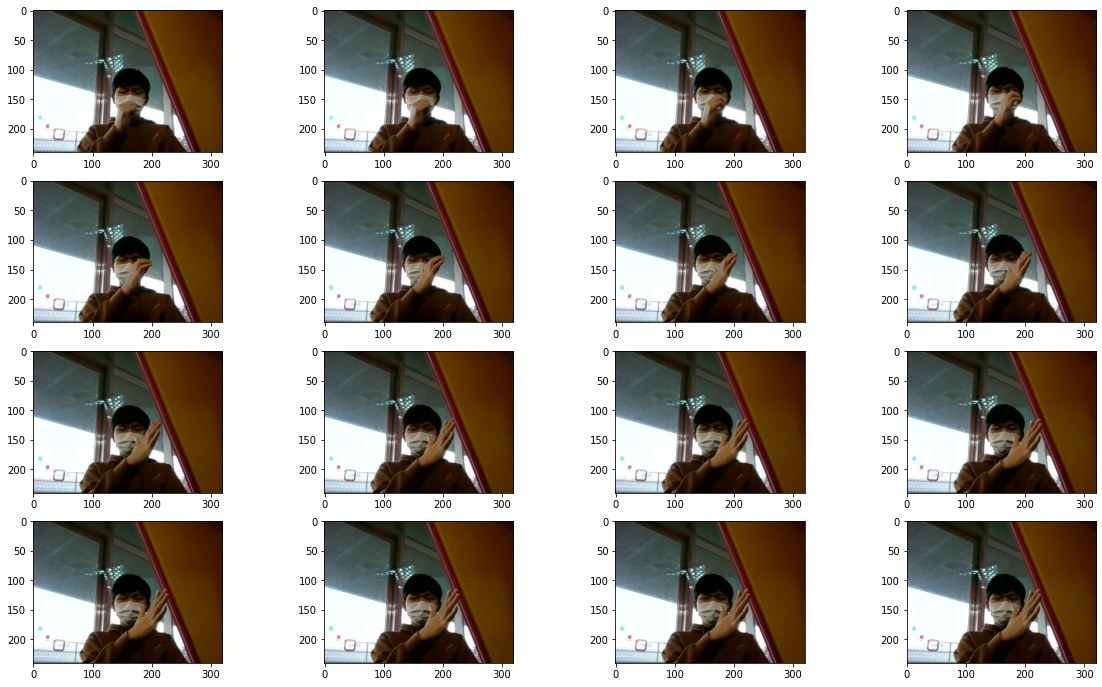

In [ ]:
example_frames = get_video_frames('paper_b', 3051 - 12, 3051 + 4)
plt.figure(figsize=(20, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(example_frames[i].numpy())

In [ ]:
class VideoDataset(torch.utils.data.Dataset):
    """
    Dataset for video.
    """

    def __init__(
        self, 
        net_type, 
        is_valid_video, 
        clip_tolerance, 
        frame_stride,
        offset,
        clip_len
    ) -> None:

        super().__init__()
        self.net_type = net_type
        self.clip_tolerance = clip_tolerance
        self.frame_stride = frame_stride
        self.clip_len = clip_len

        assert self.net_type in ['3d', '2d+lstm']

        self.videos = []
        video_lens = []

        for npy_path in Path('data').glob('*/frames.npy'):
            name = npy_path.parent.stem
            if not is_valid_video(name):
                continue
            frames = np.load(str(npy_path)) - offset
            min_f, max_f = np.min(frames), np.max(frames)

            if net_type == '2d+lstm':
                min_f += clip_len + clip_tolerance
            
            self.videos.append({
                'name': name,
                'type': hand_to_num(str(npy_path)),
                'frames': frames,
                'start': min_f,
                'end': max_f
            })
            video_lens.append(
                max_f - min_f
            )

        video_lens = np.array(video_lens)
        self.total_clips = np.sum(video_lens)
        self.cumulative = np.cumsum(video_lens)

    def __len__(self):
        return self.total_clips // self.frame_stride

    def __getitem__(self, index):
        
        if index not in range(len(self)):
            raise ValueError('Wrong index!')
        frame_num = index * self.frame_stride

        video_num = np.searchsorted(self.cumulative, frame_num, side='right')
        if video_num == 0:
            idx = frame_num
        else:
            idx = frame_num - self.cumulative[video_num - 1]

        hand_frames = self.videos[video_num]['frames']
        idx += self.videos[video_num]['start']

        start_frame = idx - self.clip_len + 1
        end_frame = idx + 1

        frames = get_video_frames(
            self.videos[video_num]['name'], start_frame, end_frame
        ) # shape: (T, H, W, C)

        frames = frames.permute(3, 0, 1, 2).to(
            dtype=torch.get_default_dtype()
        ).div(255)
        # shape: (C, T, H, W)

        frames.sub_(0.5).div_(0.5)

        target_frame = np.array([idx]) if self.net_type == '3d' else np.arange(start_frame, end_frame)
        closest_hand_shape = np.searchsorted(hand_frames, target_frame, side='right') - 1
        hand_shape_distance = target_frame - hand_frames[closest_hand_shape]

        target = self.videos[video_num]['type'] * (hand_shape_distance < self.clip_tolerance).astype(int)
        target = torch.tensor(target)

        return frames, target

## Parameters

### clip_tolerance: int
Controls how many frames after the 'hand shape point' will be considered as labeled the hand shape.

Example: `clip_tolerance == 3`
```
[... 0 0 0 3 3 3 0 0 0 ... 0 0 0 3 3 3 0 0 ...]
           ^ hand shape pos      ^ hand shape pos

(Assuming frame_stride == 1)
```
### frame_stride: int
Controls the sampling rate of the clips. Must be smaller than or equal to clip_tolerance to not miss a hand shape frame in 3d CNN nets.

Example: `frame_stride == 2` will make dataset[0] will start from frame 598 in original video, dataset[1] will start from frame 600 in original video, ...

### clip_len: int
The length of clips in frames.

### offset: int
How many frames should the model look ahead.

In [ ]:
clip_tolerance = 12
null_class_weight = clip_tolerance / (90 - clip_tolerance)

In [ ]:
train_dataset = VideoDataset(
    net_type = '2d+lstm',
    is_valid_video = (lambda x: x[-1] in 'abc'),
    clip_tolerance = clip_tolerance,
    frame_stride = 64,
    clip_len = 128,
    offset = 6
)

test_dataset = VideoDataset(
    net_type = '2d+lstm',
    is_valid_video = (lambda x: x[-1] == 'e'),
    clip_tolerance = clip_tolerance,
    frame_stride = 64,
    clip_len = 128,
    offset = 6
)

print('Train', len(train_dataset), 'Test', len(test_dataset))

Train 2382 Test 65


In [ ]:
def collate_clips(batch):
    data = torch.stack([clip[0] for clip in batch])
    target = torch.squeeze(torch.stack([clip[1] for clip in batch]))
    return data, target

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_clips
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_clips
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

torch.backends.cudnn.benchmark = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class ResNet3dBlock(nn.Module):
    def __init__(self, in_channels, out_channels=-1, stride=1):
        super().__init__()

        if out_channels == -1 or in_channels == out_channels:
            out_channels = in_channels
            self.downsample = lambda x: x
        else:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm3d(out_channels)
            )

        self.act = nn.ReLU(inplace=True)

        self.cv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)

        self.cv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        output = self.act(self.bn1(self.cv1(x)))
        output = self.bn2(self.cv2(output))

        output += self.downsample(x)
        output = self.act(output)

        return output


class Classifier3d(nn.Module):
    """
    3d CNN for simple classification. 
    
    Adapted ResNet-10 net structure of detector in
    "Real-time Hand Gesture Detection and Classification Using Convolutional Neural Networks": https://arxiv.org/abs/1901.10323

    Also refered to 
    "Can Spatiotemporal 3D CNNs Retrace the History of 2D CNNs and ImageNet?": https://arxiv.org/abs/1711.09577
    """

    def __init__(self, channel_nums, block_nums, color=True):
        super().__init__()

        in_channels = 3 if color else 1
        strides = [1, 2, 2, 2]

        self.act = nn.ReLU(inplace=True)

        self.cv1 = nn.Conv3d(in_channels, channel_nums[0], kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(channel_nums[0])
        self.mp1 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.cv_layers = nn.Sequential(*[
            self._make_layer(channel_nums[i], channel_nums[i+1], block_num=block_nums[i], stride=strides[i])
            for i in range(4)
        ])

        self.avp = nn.AdaptiveAvgPool3d(output_size=(1, 1, 1))
        self.flt = nn.Flatten()
        self.fc = nn.Linear(channel_nums[4], 4)
    
    def _make_layer(self, in_channels, out_channels, block_num, stride=1):
        blocks = []

        blocks.append(ResNet3dBlock(in_channels, out_channels, stride=stride))
        for i in range(1, block_num):
            blocks.append(ResNet3dBlock(out_channels))

        return nn.Sequential(*blocks)
        
    def forward(self, x):
        """
        Return raw scores of 3 classes.
        """
        output = self.act(self.bn1(self.cv1(x)))
        output = self.mp1(output)

        output = self.cv_layers(output)

        output = self.fc(self.flt(self.avp(output)))

        return output


In [ ]:
class Classifier2dLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = torchvision.models.resnet18()
        self.lstm = nn.LSTM(
            1000,
            32,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        
        B, C, T, H, W = x.shape

        output = self.resnet(x.transpose(1, 2).reshape(B*T, C, H, W))
        output = output.reshape(B, T, 1000)
        output = self.lstm(output)[0]
        output = self.fc(output)

        return output # shape: (B, T, 4)
        


In [ ]:
def train(net : nn.Module, device, train_loader, optimizer, epoch: int):

    print('Epoch {:#2d}'.format(epoch))
    net.train()

    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(
            [null_class_weight, 3, 3, 3], 
            dtype=torch.float, 
            device=device
        ), 
        reduction='mean'
    )

    total_loss = torch.tensor(0., device=device)
    total_right = torch.zeros(4, dtype=torch.float, device=device, requires_grad=False)
    total_num = torch.zeros(4, dtype=torch.float, device=device, requires_grad=False)
    
    with tqdm(total=len(train_loader), desc='Train') as t:
        for idx, (data, target) in enumerate(train_loader):

            start = time.time()
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad(set_to_none=True)

            output = net(data)

            output = output.flatten(end_dim=-2)
            target = target.flatten()

            loss = criterion(output, target)

            target_nums = torch.bincount(
                target,
                minlength = 4
            ).detach()
            rights = torch.bincount(
                target,
                weights = (target == output.argmax(1)),
                minlength = 4
            ).detach()
            
            loss.backward()
            optimizer.step()

            total_loss += loss.detach()
            total_num += target_nums
            total_right += rights
            elapsed = time.time() - start

            if idx % 25 == 0:
                print(
                    'batch', idx, 
                    'loss', loss.detach().item(), 
                    'num', target_nums.cpu().numpy(), 
                    'right', rights.cpu().numpy()
                )

                train_loss = total_loss.item() / (idx + 1)
                train_acc = 100. * total_right / total_num
                train_acc = train_acc.cpu().numpy()
                print('Train loss: {:6.3f}, Train acc: {}%'.format(train_loss, train_acc))
            
            t.set_postfix(t=f'{(elapsed):.4f}')
            t.update()

    train_loss = total_loss.item() / len(train_loader)

    train_acc = 100. * total_right / total_num
    train_acc = train_acc.cpu().numpy()

    print('Train loss: {:6.3f}, Train acc: {}%'.format(train_loss, train_acc))
    return train_loss, train_acc


In [ ]:
@torch.no_grad()
def test(net : nn.Module, device, test_loader):

    net.eval()

    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(
            [null_class_weight, 3, 3, 3], 
            dtype=torch.float, 
            device=device
        ), 
        reduction='mean'
    )

    total_loss = torch.tensor(0., device=device)
    # total_right_16 = torch.zeros(16, dtype=torch.float, device=device, requires_grad=False)
    total_num_16 = torch.zeros(16, dtype=torch.float, device=device, requires_grad=False)
    
    with tqdm(total=len(test_loader), desc='Test') as t:
        for idx, (data, target) in enumerate(test_loader):

            start = time.time()
            data = data.to(device)
            target = target.to(device)

            output = net(data)

            output = output.flatten(end_dim=-2)
            target = target.flatten()

            loss = criterion(output, target)
            # print(target, output)
            pred = output.argmax(1)
            target_nums = torch.bincount(
                target * 4 + pred,
                minlength = 16
            ).detach()

            total_loss += loss.detach()
            total_num_16 += target_nums
            elapsed = time.time() - start

            if idx % 25 == 0:
                print(
                    'batch', idx, 
                    'loss', loss.detach().item(), 
                    'num', target_nums.cpu().numpy(), 
                )
            
            t.set_postfix(t=f'{(elapsed):.4f}')
            t.update()

    test_loss = total_loss.item() / len(test_loader)

    confusion = total_num_16.detach().cpu().reshape(4,4).numpy()
    test_acc = np.sum(np.diagonal(confusion)) / np.sum(confusion)
    # test_acc = 100. * total_right / total_num
    # test_acc = test_acc.cpu().numpy()

    print('Test loss: {:6.3f}, Test acc: {}%'.format(test_loss, test_acc))
    return test_loss, test_acc, confusion


In [ ]:
del net
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Dec 19 10:44:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    35W / 250W |   2027MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# net = Classifier3d(
#     channel_nums=[16, 16, 32, 64, 128],
#     block_nums=[1, 1, 1, 1]
# ).to(device)

net = Classifier2dLSTM().to(device)

# torchsummary.summary(net, (3, 256, 240, 320))
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [ ]:
from datetime import datetime

def save_model(net, path=None, epoch=0):
    if path is None:
        path = '/gdrive/My Drive/CS492I/2021F_CS492/ckpts/{}_{}.pt'.format(
            datetime.now().strftime('%Y%m%d_%H%M%S'),
            str(epoch)
        )
    torch.save(net.state_dict(), path)
    print(' -> Saved', end='')

In [ ]:
best_acc = 0

for epoch in range(1,10):
    train(net, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(net, device, test_loader)

    if best_acc < test_acc.mean():
        save_model(net, epoch=epoch)
        best_acc = test_acc.mean()

In [ ]:
net.load_state_dict(torch.load('/gdrive/My Drive/CS492I/2021F_CS492/ckpts/20211207_093153_7.pt', map_location=device))

results = test(net, device, train_loader)
print(results)

Test:   0%|          | 0/1191 [00:00<?, ?it/s]

batch 0 loss 0.5131084322929382 num [116 111   0   5   1  23   0   0   0   0   0   0   0   0   0   0]
batch 25 loss 0.47773030400276184 num [175  42   0   6   8  13   0   0   0   0   0   0   0   0   0  12]
batch 50 loss 0.3491857349872589 num [132   9  69   0   2  22   0   0   0   0  22   0   0   0   0   0]
batch 75 loss 0.453704833984375 num [129   0  69  34   0   0   0   0   0   0  12   0   0   0   0  12]
batch 100 loss 0.3631163239479065 num [152  55   0  12   0  24   0   0   0   0   0   0   0   0   0  13]
batch 125 loss 0.8177614212036133 num [204   0   3  13   0   0   0   0  12   0  12   0   0   0   0  12]
batch 150 loss 0.2705138027667999 num [171  24  25   0   0  12   0   0   0   0  24   0   0   0   0   0]
batch 175 loss 0.20555001497268677 num [163   0  44  13   0   0   0   0   0   0  24   0   0   0   0  12]
batch 200 loss 0.27661222219467163 num [159   0  26  23   0   0   0   0   3   0  21   0   0   0   0  24]
batch 225 loss 0.3329073488712311 num [108   0 112   0   0   0   0 

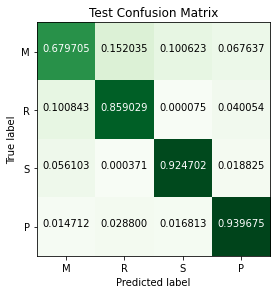

In [ ]:
import itertools

def foo():
    conf = results[-1]

    for i in range(4):
        conf[i] /= np.sum(conf[i])

    classes = ['M', 'R', 'S', 'P']
    # plot confusion matrix
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("Test Confusion Matrix")
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'f'
    thresh = conf.max() / 2.
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, format(conf[i, j], fmt),
                horizontalalignment="center",
                color="white" if conf[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

foo()

In [ ]:
sum([77.4708, 93.1677, 95.1407, 93.7855]) / 4

89.891175

In [ ]:
with torch.no_grad():
    start = time.time()
    print(net(torch.randn(1, 3, 128, 240, 320, device=device))[0, 126].tolist())
    print(time.time() - start)

[-0.7927454710006714, -0.43292343616485596, 0.029882483184337616, 1.055880069732666]
0.08517718315124512
